# Data Exploration


Also need to think about how to handle the multiple waves per person. Options:
1. Keep all waves (will need to use panel data methods)
2. Keep only one wave per person (will need to decide which wave to keep - most recent? random?)
3. Average across waves (will need to decide how to handle missing data - if a person is missing in one wave but not another, do we keep the non-missing value?)
4. Use only the first wave a person appears in (will lose a lot of data, but will be simpler to analyze)

**Reminder**
- Independent variable = X = informal institutions = nbrsnci_dv = Higher values represent greater cohesion, ranging from 1 “lowest cohesion” to 5 “highest cohesion”.
- Dependent variable = Y = subjective wellbeing = scghq1_dv = Range of scores from 0 (indicating the least amount of distress) to 36 (indicating the greatest amount of distress)

In [17]:
import pandas as pd                                 
from pathlib import Path                           
import matplotlib.pyplot as plt                     
import seaborn as sns                              
import numpy as np                                  
from scipy.stats import norm                        
from sklearn.preprocessing import StandardScaler    
from scipy import stats                             
import statsmodels.api as sm                       
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)  # Show all columns when displaying a dataframe
import pyreadstat

In [18]:
# Import file

path = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/refinedvariables.dta"
df, meta = pyreadstat.read_dta(path)

print("Shape:", df.shape)
df.head()

Shape: (175335, 18)


,pidp,wave,wave_num,hidp,nbrsnci_dv,gor_dv,urban_dv,sex_dv,age_dv,ethn_dv,marstat_dv,jbstat,qfhigh_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,scghq1_dv
0,1428960167,f,6,1431984810,3.1,7,1,1,50,4,1,1,2,387060.718750,395352.65625,0.0,2,12
1,1156946571,f,6,1159984810,4.0,7,1,1,54,1,1,1,96,387021.562500,389177.56250,234.0,2,10
2,680442005,c,3,689343204,3.5,6,1,1,56,1,1,2,-8,350391.562500,353373.56250,1200.0,2,8
3,350438086,f,6,348132810,3.5,2,1,1,58,1,5,1,1,293018.343750,303066.28125,360.0,1,7
4,615375525,f,6,620921610,3.1,2,1,1,34,1,1,1,96,252226.890625,253935.21875,700.0,2,6


In [19]:
# Create a table showing the number of observations in each wave

wave_table = df['wave'].value_counts().sort_index()

display(wave_table)

wave
a    37988
c    40509
f    35472
i    33137
l    28229
Name: count, dtype: int64

Great! For now, I'll just use data from wave C, which has the highest number of observations.

In [20]:
# Drop all waves except wave c

df = df[df['wave'] == 'c']
print("Shape after dropping waves:", df.shape)

Shape after dropping waves: (40509, 18)


## Describe statistics for dependent variable

In [21]:
# define the dependent variable, Y

Y = df['scghq1_dv']

Y.describe()

count    40509.000000
mean        11.074946
std          5.519019
min          0.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         36.000000
Name: scghq1_dv, dtype: float64

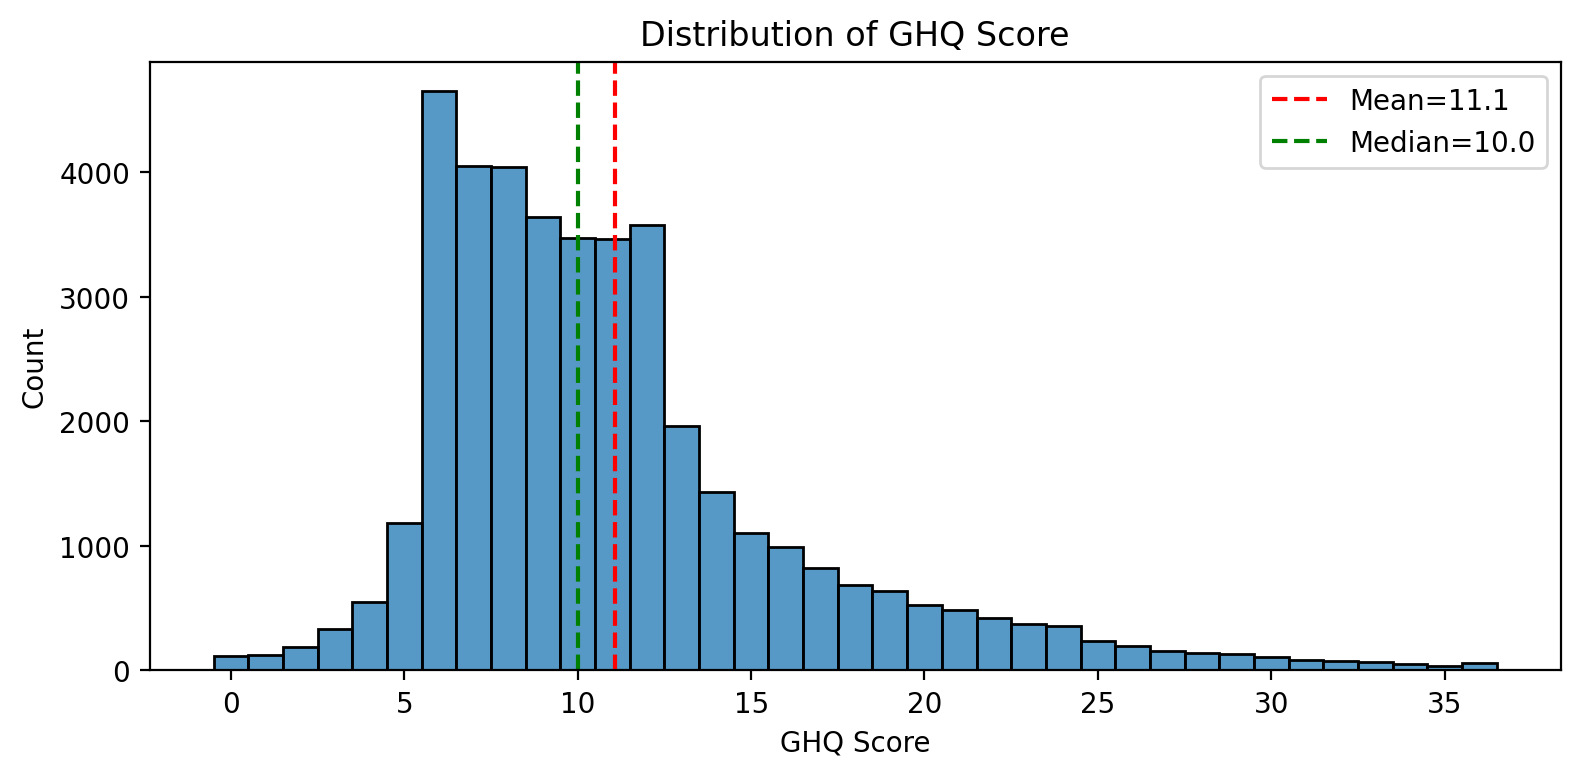

In [42]:
# Histogram of Y (GHQ score)
bins = np.arange(Y.min() - 0.5, Y.max() + 1.5, 1)
plt.figure(figsize=(8, 4))
sns.histplot(Y, bins=bins, stat="count", kde=False, color='C0')
plt.axvline(Y.mean(), color="red", linestyle="--", label=f"Mean={Y.mean():.1f}")
plt.axvline(Y.median(), color="green", linestyle="--", label=f"Median={Y.median():.1f}")
plt.title('Distribution of GHQ Score')
plt.xlabel('GHQ Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
print("Skewness: %f" %Y.skew())
print("Kurtosis: %f" %Y.kurt())

Skewness: 1.455205
Kurtosis: 2.654516
